# Transformer notebook

## Install packages

In [19]:
!python -m pip install ipywidgets

   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   ----------------- ---------------------- 61.4/139.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 139.4/139.4 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/215.0 kB ? eta -:--:--
   -------------------- ------------------- 112.6/215.0 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 215.0/215.0 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.3 MB 7.5 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/2.3 MB 2.8 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.3 MB 2.9 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.3 MB 2.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.7/2.3 MB 3.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.9/2.3 MB 3.4 MB/s eta 0:00:01
   -----------


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
!python -m pip install datasets torch torchtext

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.9 MB 2.0 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/1.9 MB 2.6 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/1.9 MB 2.4 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/1.9 MB 2.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/1.9 MB 2.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/1.9 MB 2.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.9 MB 2.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/1.9 MB 2.5 MB/s eta 0:00:01
   -------------------- ------------------- 1.0/1.9 MB 2.5 MB/s eta 0:00:01
   ----------------------- ---------------- 1.1/1.9 MB 2.5 MB/s eta 0:00:01
   ------------------------- -------------- 1.2/1.9 MB 2.5 MB/s eta 0:00:01
   --------------------------- ------------ 1.3/1.9 MB 2.4 MB/s eta 0:00:01
   ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.2.1 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.2.1 which is incompatible.
xformers 0.0.22 requires torch==2.0.1, but you have torch 2.2.1 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [20]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import math


Text(0, 0.5, 'sine')

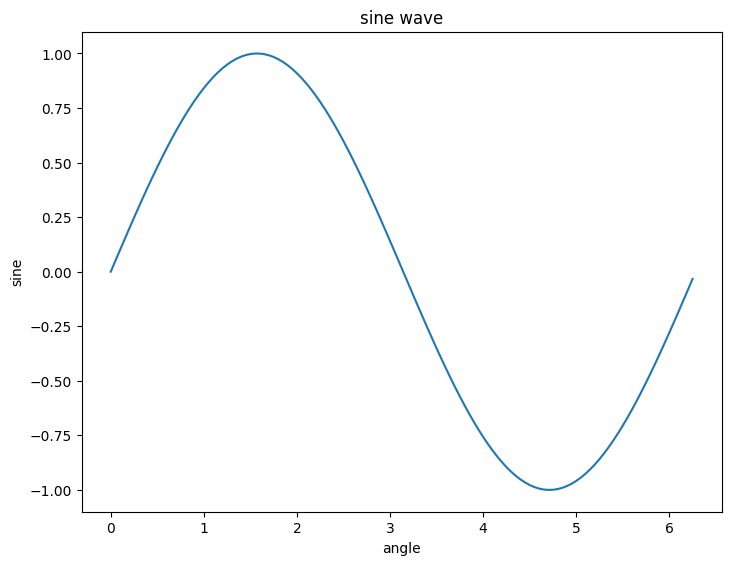

In [10]:
%matplotlib inline
x=np.arange(0,math.pi*2, 0.05)
y=np.sin(x)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(x,y)
ax.set_title("sine wave")
ax.set_xlabel('angle')
ax.set_ylabel('sine')